<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/books/diffusion_imaging/mrtrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>   </a>

# MRtrix

Author:

Citation:

## Setup Neurodesk

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

In [2]:
# Output CPU information:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: AuthenticAMD
model name	: AMD EPYC 7742 64-Core Processor


In [6]:
%%capture
! pip install nibabel matplotlib

In [7]:
import subprocess
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tempfile

## Introduction

In [1]:
# load fmriprep
import lmod
import os
await lmod.load('mrtrix3/3.0.4')
await lmod.load('mrtrix3tissue/5.2.8')
await lmod.list()

['mrtrix3/3.0.4', 'mrtrix3tissue/5.2.8', 'fsl/6.0.4']

## Data preparation

In [2]:
# download data
!datalad install https://github.com/OpenNeuroDatasets/ds002080.git
!cd ds002080 && datalad get sub-CON02

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                              | 0.00/20.6k [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                           | 0.00/12.7k [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/22.6k [00:00<?, ? Objects/s]
Receiving:   9%|█▊                  | 2.03k/22.6k [00:00<00:01, 17.0k Objects/s]
Receiving:  29%|█████▊              | 6.54k/22.6k [00:00<00:00, 32.2k Objects/s]
Receiving:  45%|█████████           | 10.1k/22.6k [00:00<00:00, 32.1k Objects/s]
Receiving:  60%|████████████        | 13.5k/22.6k [00:00<00:00, 28.3k Objects/s]
Receiving:  90%|██████████████████  | 20.3k/22.6k [00:00<00:00, 40.6k Objects/s]
               

## Preprocessing
Diffusion data in particular is susceptible to warping artifacts as a result of the phase-encoding direction: In general, the predominant encoding direction - such as Anterior to Posterior, or AP - will make the anterior part of the brain look more “squished”, as though a strong headwind is blowing from the Anterior direction. The opposite is true of the Posterior to Anterior, or PA, phase-encoding direction. Sometimes these distortions are very subtle, but other times they are conspicuous.

The following are common preprocessing steps done with MRtrix. If you have used the software package FSL to analyze diffusion data, note that some of the FSL commands - such as eddy and topup - are used in some of the MRtrix libraries. 

### dwi_denoise

The first preprocessing step we will do is denoise the data by using MRtrix’s ```dwidenoise``` command. This requires an input and an output argument, and you also have the option to output the noise map with the *-noise* option. For example:

In [3]:
!dwidenoise ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz dwi.mif -noise noise.mif

dwidenoise: [100%] uncompressing image "ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz"[0K
dwidenoise: [100%] preloading data for "ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz"[0K
dwidenoise: [100%] running MP-PCA denoising[0K


### dwipreproc

Most diffusion datasets are composed of two separate imaging files: One that is acquired with a primary phase-encoding direction, and one that is acquired with a reverse phase-encoding direction. The primary phase-encoding direction is used to acquire the majority of the diffusion images at different b-values. The reverse-phase encoded file, on the other hand, is used to unwarp any of the distortions that are present in the primary phase-encoded file.

Our first step is to convert the reverse phase-encoded NIFTI file into .mif format. We will also add its b-values and b-vectors into the header:

In [12]:
!mrconvert ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.nii.gz PA.mif
!mrconvert PA.mif -fslgrad ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.bvec ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.bval - | mrmath - mean mean_b0_PA.mif -axis 3

mrconvert: [100%] uncompressing image "ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-PA_dwi.nii.gz"[0K
mrconvert: [ERROR] output file "PA.mif" already exists (use -force option to force overwrite)
mrconvert: [ERROR] error creating image "PA.mif"
mrconvert: [100%] copying from "PA.mif" to "/tmp/mrtrix-tmp-hNE0b4.mif"[0K
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-hNE0b4.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K


Next, we extract the b-values from the primary phase-encoded image, and then combine the two with ```mrcat```. This will create a new image, “b0_pair.mif”, which contains both of the average b=0 images for both phase-encoded images.

In [14]:
!dwiextract dwi.mif - -fslgrad ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bvec ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bval -bzero | mrmath - mean mean_b0_AP.mif -axis 3
!mrcat mean_b0_AP.mif mean_b0_PA.mif -axis 3 b0_pair.mif

dwiextract: [100%] extracting volumes[0K
mrmath: [100%] preloading data for "/tmp/mrtrix-tmp-xtHviK.mif"[0K
mrmath: [100%] computing mean along axis 3...[0K
mrcat: [100%] concatenating "mean_b0_AP.mif"[0K
mrcat: [100%] concatenating "mean_b0_PA.mif"[0K


##### 
We now have everything we need to run the main preprocessing step, which is called by ```dwipreproc```. For the most part, this command is a wrapper that uses FSL commands such as ```topup``` and ```eddy``` to unwarp the data and remove eddy currents.

The first arguments are the input and output; the second option, *-nocleanup*, will keep the temporary processing folder which contains a few files we will examine later. *-pe_dir AP* signalizes that the primary phase-encoding direction is anterior-to-posterior, and *-rpe_pair* combined with the *-se_epi* options indicates that the following input file (i.e., “b0_pair.mif”) is a pair of spin-echo images that were acquired with reverse phase-encoding directions. 

Lastly, *-eddy_options* specifies options that are specific to the FSL command ```eddy```. You can visit the eddy user guide for more options and details about what they do. For now, we will only use the options *--slm=linear* (which can be useful for data that was acquired with less than 60 directions) and *--data_is_shelled* (which indicates that the diffusion data was acquired with multiple b-values).

#####

In [17]:
!dwifslpreproc dwi.mif dwi_preproc.mif -fslgrad ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bvec ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bval -pe_dir AP -rpe_pair -se_epi b0_pair.mif -eddy_options " --slm=linear --data_is_shelled"

dwifslpreproc: 
dwifslpreproc: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwifslpreproc: 
dwifslpreproc: Generated scratch directory: /neurodesktop-storage/dwifslpreproc-tmp-280EMZ/
Command:  mrconvert /neurodesktop-storage/dwi.mif /neurodesktop-storage/dwifslpreproc-tmp-280EMZ/dwi.mif -fslgrad /neurodesktop-storage/ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bvec /neurodesktop-storage/ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.bval -json_export /neurodesktop-storage/dwifslpreproc-tmp-280EMZ/dwi.json
Command:  mrconvert /neurodesktop-storage/b0_pair.mif /neurodesktop-storage/dwifslpreproc-tmp-280EMZ/se_epi.mif
dwifslpreproc: Changing to scratch directory (/neurodesktop-storage/dwifslpreproc-tmp-280EMZ/)
dwifslpreproc: Total readout time not provided at command-line; assuming sane

####
When it has finished running, examine the output to see how eddy current correction and unwarping have changed the data; ideally, you should see more signal restored in regions such as the orbitofrontal cortex, which is particularly susceptible to signal dropout.

Let's display the newly preprocessed data, with the original diffusion data overlaid on top of it and colored in red. You should see a noticeable difference between the two images, especially in the frontal lobes of the brain near the eyes, which are most susceptible to eddy currents.

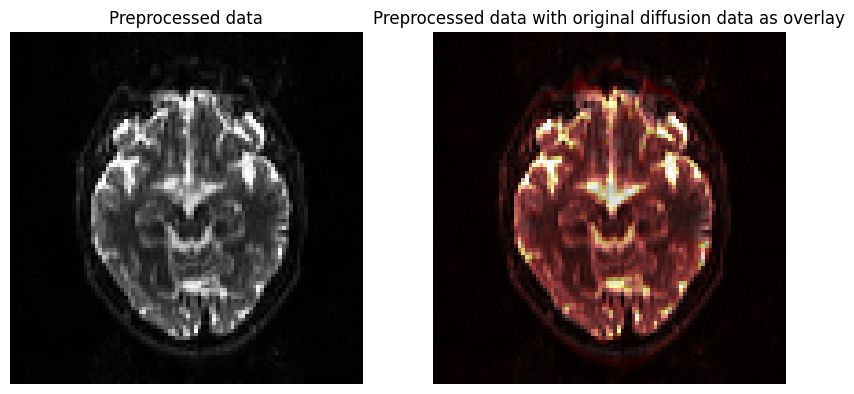

In [8]:
# File paths for both images
mif_file_path1 = 'dwi_preproc.mif'  
mif_file_path2 = 'ds002080/sub-CON02/ses-postop/dwi/sub-CON02_ses-postop_acq-AP_dwi.nii.gz'          

# Convert both .mif files to temporary .nii.gz files with -force flag
with tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file1, \
     tempfile.NamedTemporaryFile(suffix=".nii.gz") as temp_file2:
         
    # Convert main image
    result1 = subprocess.run(["mrconvert", mif_file_path1, temp_file1.name, "-force"], capture_output=True, text=True)
    if result1.returncode != 0:
        print(f"Error in mrconvert for preprocessed image: {result1.stderr}")
        exit()
    
    # Convert overlay image
    result2 = subprocess.run(["mrconvert", mif_file_path2, temp_file2.name, "-force"], capture_output=True, text=True)
    if result2.returncode != 0:
        print(f"Error in mrconvert for original image: {result2.stderr}")
        exit()
         
    # Load the converted images
    nii_image1 = nib.load(temp_file1.name)
    nii_image2 = nib.load(temp_file2.name)

    data1 = nii_image1.get_fdata()
    data2 = nii_image2.get_fdata()

    # Select middle slice 
    slice_index = data1.shape[2] // 3

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Plot preprocessed data
    axes[0].imshow(np.rot90(data1[:, :, slice_index, 0]), cmap="Greys_r", vmin=0, vmax=1000)
    axes[0].set_title("Preprocessed data")
    axes[0].axis("off")

    # Plot original diffusion data as overlay
    axes[1].imshow(np.rot90(data1[:, :, slice_index, 0]), cmap="Greys_r", vmin=0, vmax=1000) 
    axes[1].imshow(np.rot90(data2[:, :, slice_index, 0]), cmap="hot", alpha=0.4, vmin=0, vmax=1000) 
    axes[1].set_title("Preprocessed data with original diffusion data as overlay")
    axes[1].axis("off")
    plt.show()

In [18]:
!dwibiascorrect ants dwi_preproc.mif dwi_denoised_preproc_unbiased.mif -bias bias.mif

dwibiascorrect: 
dwibiascorrect: Note that this script makes use of commands / algorithms that have relevant articles for citation; INCLUDING FROM EXTERNAL SOFTWARE PACKAGES. Please consult the help page (-help option) for more information.
dwibiascorrect: 
dwibiascorrect: Generated scratch directory: /neurodesktop-storage/dwibiascorrect-tmp-A160C8/
Command:  mrconvert /neurodesktop-storage/dwi_preproc.mif /neurodesktop-storage/dwibiascorrect-tmp-A160C8/in.mif
dwibiascorrect: Changing to scratch directory (/neurodesktop-storage/dwibiascorrect-tmp-A160C8/)
Command:  dwi2mask in.mif mask.mif
Command:  dwiextract in.mif - -bzero | mrmath - mean mean_bzero.mif -axis 3
Command:  mrconvert mean_bzero.mif mean_bzero.nii -strides +1,+2,+3
Command:  mrconvert mask.mif mask.nii -strides +1,+2,+3
Command:  N4BiasFieldCorrection -d 3 -i mean_bzero.nii -w mask.nii -o [corrected.nii,init_bias.nii] -s 4 -b [100,3] -c [1000,0.0]
Command:  mrcalc mean_bzero.mif mask.mif -mult - | mrmath - sum - -axis 0

## 3-tissue response function estimation
A robust and fully automated unsupervised method to obtain 3-tissue response functions representing single-fibre white matter (WM), grey matter (GM) and CSF from the data itself, is available as the so-called dwi2response dhollander comman from `MRtrix3Tissue` package 

In [19]:
!dwi2response dhollander dwi_denoised_preproc_unbiased.mif wm.txt gm.txt csf.txt -voxels voxels.mif

dwi2response: 
dwi2response: Note that this script makes use of commands / algorithms that have relevant articles for citation. Please consult the help page (-help option) for more information.
dwi2response: 
dwi2response: Generated scratch directory: /neurodesktop-storage/dwi2response-tmp-H83N3A/
dwi2response: Importing DWI data (/neurodesktop-storage/dwi_denoised_preproc_unbiased.mif)...
dwi2response: Changing to scratch directory (/neurodesktop-storage/dwi2response-tmp-H83N3A/)
dwi2response: Computing brain mask (dwi2mask)...
dwi2response: -------
dwi2response: 4 unique b-value(s) detected: 0,700,1200,2800 with 6,16,30,50 volumes
dwi2response: -------
dwi2response: Preparation:
dwi2response: * Eroding brain mask by 3 pass(es)...
dwi2response:   [ mask: 95789 -> 68783 ]
dwi2response: * Computing signal decay metric (SDM):
dwi2response:  * b=0...
dwi2response:  * b=700...
dwi2response:  * b=1200...
dwi2response:  * b=2800...
dwi2response: * Removing erroneous voxels from mask and corr

In [32]:
!mrgrid dwi_denoised_preproc_unbiased.mif regrid dwi_denoised_preproc_unbiased_upsampled.mif -voxel 1.5
!mrgrid dwi_mask.mif regrid - -template dwi_denoised_preproc_unbiased_upsampled.mif -interp linear -datatype bit | maskfilter - median dwi_mask_upsampled.mif

mrgrid: [100%] reslicing "dwi_denoised_preproc_unbiased.mif"reproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... [?7hicing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... oc_unbiased.mif"... icing "dwi_denoised_preproc_unbiased.mif"... ... icing "dwi_denoised_preproc_unbia

In [33]:
!dwi2mask dwi_denoised_preproc_unbiased_upsampled.mif dwi_mask_upsampled.mif

dwi2mask: [  5%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... .mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 15%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... oc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 25%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... ] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 34%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 43%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... oc_unbiased_upsampled.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 52%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... d.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 61%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 70%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 79%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 88%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [ 96%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... ed.mif"... ed.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2mask: [100%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"r "dwi_denoised_preproc_unbiased_upsampled.mif"... ed.mif"... oc_unbiased_upsampled.mif"... 
dwi2mask: [100%] finding min/max of "mean b=0 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=700 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=1200 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [100%] finding min/max of "mean b=2800 image"
dwi2mask: [done] optimising threshold
dwi2mask: [100%] thresholding
dwi2mask: [done] computing dwi brain mask
dwi2mask: [ERROR] output file "dwi_mask_upsampled.mif" already exists (use -force option to force overwrite)
dwi2mask: [ERROR] error creating image "dwi_mask_upsampled.mif"


## 3-tissue CSD modelling
Your data is now ready for 3-tissue CSD modelling with the previously obtained 3-tissue response functions, which will result in modelling the diffusion MRI data using WM-like (FOD), GM-like and CSF-like compartments. There are 2 different methods (or algorithms) available to perform 3-tissue CSD. The choice between both depends on what (part of your) data you intend to perform 3-tissue CSD modelling for.

If you want to perform 3-tissue CSD modelling for multi-shell data, this can be achieved using the multi-shell multi-tissue CSD (MSMT-CSD) method or algorithm, as follows:

In [70]:
!dwi2fod msmt_csd dwi_denoised_preproc_unbiased_upsampled.mif wm.txt wmfod.mif gm.txt gm.mif csf.txt csf.mif -mask dwi_mask_upsampled.mif

dwi2fod: [  5%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 15%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 25%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 35%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 45%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 54%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 64%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 70%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 74%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 83%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 92%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [100%] preloading data for "dwi_denoised_preproc_unbiased_upsampled.mif"
dwi2fod: [  5%] performing multi-shell, multi-tissue CSD... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [ 10%] performing multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



dwi2fod: [100%] performing multi-shell, multi-tissue CSDi-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell, multi-tissue CSD... i-tissue CSD... i-tissue CSD... forming multi-shell,

 get CSF mask from csf spherical harmonic coefficients applying the first criteria (aka the csf.mif file):

In [71]:
!mrconvert wmfod.mif -coord 3 0 -axes 0,1,2 - | mrcalc csf.mif gm.mif - -add 5 -mult -gt csf_mask1.mif-datatype bit

mrconvert: [ 32%] copying from "wmfod.mif" to "/tmp/mrtrix-tmp-cuTb01.mif"... " to "/tmp/mrtrix-tmp-cuTb01.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mrconvert: [ 81%] copying from "wmfod.mif" to "/tmp/mrtrix-tmp-cuTb01.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mrconvert: [100%] copying from "wmfod.mif" to "/tmp/mrtrix-tmp-cuTb01.mif"
mrcalc: [100%] computing: (csf.mif > ((gm.mif + /tmp/mrtrix-tmp-cuTb01.mif) * 5))


get CSF mask from second criteria (note: 0.141047 might be half of max response function)

In [72]:
!mrthreshold csf.mif csf_mask2.mif -abs 0.141047

mrthreshold: [100%] Determining and applying per-volume thresholds


Getting the overlap of both masks:

In [73]:
!mrcalc csf_mask1.mif csf_mask2.mif -mult csf_maskcombined.mif -datatype bit

mrcalc: [100%] computing: (csf_mask1.mif * csf_mask2.mif)


In [80]:
!mrconvert dwi_denoised_preproc_unbiased_upsampled.mif reduced.mif -coord 3 $(cat bval_less_1000.txt)

mrconvert: [ 36%] copying from "dwi_denois...proc_unbiased_upsampled.mif" to "reduced.mif"... duced.mif"... dwi_denois...proc_unbiased_upsampled.mif" to "reduced.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



mrconvert: [ 93%] copying from "dwi_denois...proc_unbiased_upsampled.mif" to "reduced.mif"... 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [82]:
!dwi2adc reduced.mif dwi_adc.mif

dwi2adc: [100%] computing ADC values] computing ADC values... 


In [83]:
!mrconvert dwi_adc.mif extracted_adc.mif -coord 3 1

mrconvert: [100%] copying from "dwi_adc.mif" to "extracted_adc.mif"


In [87]:
!mrcalc extracted_adc.mif csf_maskcombined2.mif -mult masked_adc.mif

mrcalc: [100%] computing: (extracted_adc.mif * csf_maskcombined2.mif)


## Results

In [88]:
!mrcalc 2256.74 4.39221 masked_adc.mif -divide -log -divide 273.15 -subtract masked_temperature.mif

mrcalc: [100%] computing: ((2256.74 / log ((4.39221 / masked_adc.mif))) - 273.15)
